# Transfer Learning

### Задача 
Обучить СНС с помощью Transfer Learning на датасете Food-101.<br>
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.<br>
Библиотеки: [Python, Tensorflow]

### Решение

### Загружаем библиотеки

In [ ]:
%tensorflow_version 2.x
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MY_DRIVE_PATH = '/content/drive/My Drive/Colab Notebooks/Computer_vision/Models'

### Загружаем и распаковываем архив Food-101

In [ ]:
# !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
# !tar xzvf food-101.tar.gz
# !rm food-101.tar.gz

### Посмотрим, что в архиве

In [ ]:
# !apt-get install tree

In [ ]:
!tree food-101 -C -L 1

food-101
├── images
├── license_agreement.txt
├── meta
├── README.txt
├── test
└── train

4 directories, 2 files


In [ ]:
!tree food-101/meta -C -L 1

food-101/meta
├── classes.txt
├── labels.txt
├── test.json
├── test.txt
├── train.json
└── train.txt

0 directories, 6 files


В папке images хранятся изображения разбитые на 101 папку с именами классов

In [ ]:
!tree food-101/images -C -L 1 | head
print('...')

food-101/images
├── apple_pie
├── baby_back_ribs
├── baklava
├── beef_carpaccio
├── beef_tartare
├── beet_salad
├── beignets
├── bibimbap
├── bread_pudding
...


Выведем список имен всех классов

In [ ]:
IMAGES_DIR = 'food-101/images/'

full_classes_list = sorted(os.listdir(IMAGES_DIR))

for i, cl in enumerate(full_classes_list):
    print(f'{cl:<24}', end=' ')
    if (i + 1) % 5 == 0:
        print()

apple_pie                baby_back_ribs           baklava                  beef_carpaccio           beef_tartare             
beet_salad               beignets                 bibimbap                 bread_pudding            breakfast_burrito        
bruschetta               caesar_salad             cannoli                  caprese_salad            carrot_cake              
ceviche                  cheese_plate             cheesecake               chicken_curry            chicken_quesadilla       
chicken_wings            chocolate_cake           chocolate_mousse         churros                  clam_chowder             
club_sandwich            crab_cakes               creme_brulee             croque_madame            cup_cakes                
deviled_eggs             donuts                   dumplings                edamame                  eggs_benedict            
escargots                falafel                  filet_mignon             fish_and_chips           foie_gras         

### Визуализация датасета Food101
Возьмем 10 случайных классов и выведем примеры из каждого

In [ ]:
classes10 = list(np.random.choice(full_classes_list, 10))
print(*classes10, sep=', ')

omelette, carrot_cake, shrimp_and_grits, donuts, gyoza, donuts, sashimi, baklava, ice_cream, bruschetta


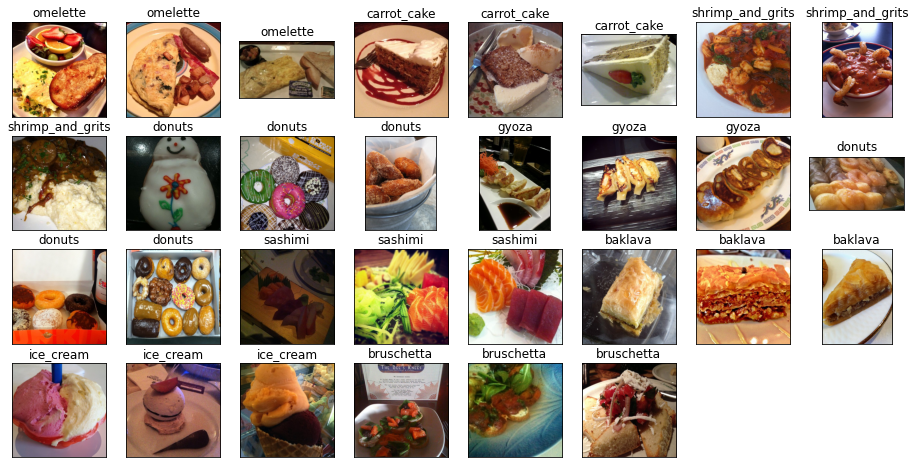

In [ ]:
fig = plt.figure(figsize=(16, 8))
i = 0
for cl in classes10:
    image_dirs = os.listdir(os.path.join(IMAGES_DIR, cl))
    image_titles = np.random.choice(image_dirs, 3)

    for image_title in image_titles:
        i += 1
        img = plt.imread(os.path.join(IMAGES_DIR, cl, image_title))
        ax = fig.add_subplot(4, 8, i)
        ax.imshow(img)
        ax.set_title(cl)
        plt.xticks([]), plt.yticks([])
plt.show()

### Сформируем тренировочную и тестовую выборку

В архиве уже есть текстовые файлы `train.txt` и `test.txt` со списками изображений для тестовой и тренировочной выборки. 

Воспользуемся ими. Сформируем папки `train` и `test`.
Для этого уже есть готовый код из интернета.

In [ ]:
from shutil import copy, copytree, rmtree
from collections import defaultdict

MAIN_DIR = 'food-101'

def create_dataset(data_type):
    folder = os.path.join(MAIN_DIR, data_type)
    print(f'Формируем {data_type} ...')
    classes = defaultdict(list)

    with open(os.path.join(MAIN_DIR, 'meta', f'{data_type}.txt'), 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            dir_file = p.split('/')
            classes[dir_file[0]].append(dir_file[1] + '.jpg')

    for cl in classes.keys():
        if not os.path.exists(os.path.join(folder, cl)):
            os.makedirs(os.path.join(folder, cl))
        for i in classes[cl]:
            copy(os.path.join(IMAGES_DIR, cl, i), os.path.join(folder, cl, i))
    print(f'{data_type} сформирован.')

In [ ]:
%%time
create_dataset('train')
create_dataset('test')

Формируем train ...
train сформирован.
Формируем test ...
test сформирован.
CPU times: user 6.59 s, sys: 14.8 s, total: 21.4 s
Wall time: 1min 57s


Считаем число тренировочных изображений

In [ ]:
N_TRAIN_SAMPLES = 0
for root, dirs, files in os.walk(os.path.join(MAIN_DIR, 'train')):
    N_TRAIN_SAMPLES += len(files)
N_TRAIN_SAMPLES

75750

Считаем число тестовых изображений

In [ ]:
N_TEST_SAMPLES = 0
for root, dirs, files in os.walk(os.path.join(MAIN_DIR, 'test')):
    N_TEST_SAMPLES += len(files)
N_TEST_SAMPLES

25250

### Создаем модель

Будем использовать аугментацию, увеличивая наш датасет. Поворачиваем, зуммируем изображение, а также отражаем горизонтально.

Сама модель на основе InceptionV3, обученной на ImageNet

Также добавлен полносвязный слой в конце с дропаутом.

На выходном слое исопльзуется L2-регуляризация.

In [ ]:
INP_SIZE = 299
BATCH_SIZE = 32

N_CLASSES = len(full_classes_list)

TRAIN_DIR = os.path.join(MAIN_DIR, 'train')
TEST_DIR = os.path.join(MAIN_DIR, 'test')

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(INP_SIZE, INP_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

val_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(INP_SIZE, INP_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

def create_model():
    base_model = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet')

    l2_reg = tf.keras.regularizers.l2(5e-3)

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(
            N_CLASSES, 
            kernel_regularizer=l2_reg, 
            activation='softmax'),])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])      

    return model                                                   

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [ ]:
%%time
tf.keras.backend.clear_session()
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               25957     
Total params: 22,353,285
Trainable params: 22,318,853
Non-trainable params: 34,432
_________________________________________________________________
CPU times: user 3.6 s, sys: 157 ms, total: 3.76 s
Wall time: 3.72 s


### Обучение и сохранение моделей
В процессе обучения будем сохранять веса моделей, чтобы потом можно было их сравнить.

In [ ]:
%%time
model.load_weights(os.path.join(MY_DRIVE_PATH, 'food101_wghts_loss5.85_acc0.52.hdf5'))

NUM_EPOCHS = 20

callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(
        MY_DRIVE_PATH, 
        'food101_wghts_loss{val_loss:.2f}_acc{val_accuracy:.2f}.hdf5'), 
    save_weights_only=True,
    monitor='val_accuracy')

history = model.fit(
    train_gen,
    steps_per_epoch=N_TRAIN_SAMPLES // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=N_TEST_SAMPLES // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[callback])

Epoch 1/20
2367/2367 [==============================] - 1988s 840ms/step - loss: 4.9784 - accuracy: 0.5088 - val_loss: 4.0841 - val_accuracy: 0.5362
Epoch 2/20
2367/2367 [==============================] - 1983s 838ms/step - loss: 3.5228 - accuracy: 0.5588 - val_loss: 2.9065 - val_accuracy: 0.5912
Epoch 3/20
2367/2367 [==============================] - 1912s 808ms/step - loss: 2.5867 - accuracy: 0.5920 - val_loss: 2.3041 - val_accuracy: 0.5769
Epoch 4/20
2367/2367 [==============================] - 1942s 820ms/step - loss: 1.9168 - accuracy: 0.6213 - val_loss: 1.6645 - val_accuracy: 0.6361
Epoch 5/20
2367/2367 [==============================] - 1909s 806ms/step - loss: 1.5746 - accuracy: 0.6460 - val_loss: 2.1599 - val_accuracy: 0.5252
Epoch 6/20
2367/2367 [==============================] - 1926s 814ms/step - loss: 1.4177 - accuracy: 0.6654 - val_loss: 1.4491 - val_accuracy: 0.6547
Epoch 7/20
2367/2367 [==============================] - 1879s 794ms/step - loss: 1.3208 - accuracy: 0.6858

### Оценка качества модели

In [ ]:
%%time
model.evaluate(val_gen)

790/790 [==============================] - 230s 291ms/step - loss: 5.9804 - accuracy: 0.5160
CPU times: user 3min 52s, sys: 15.1 s, total: 4min 7s
Wall time: 3min 50s


[5.980413436889648, 0.5160396099090576]

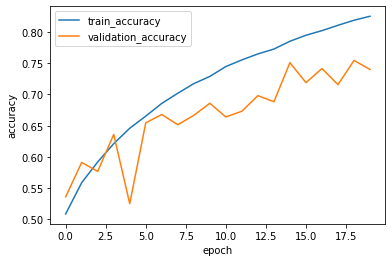

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

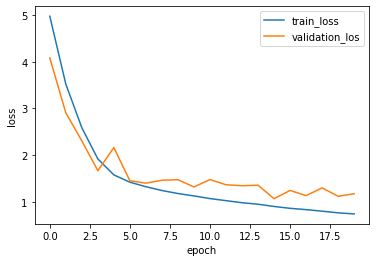

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_los'], loc='best')
plt.show()

##Запуск предсказания на нашем изображении

Скачаем пиццу и проверим на ней работу модели

In [ ]:
#!wget https://i.pinimg.com/originals/e1/37/26/e1372657d9a016f62ec0b88a7de21ad8.jpg

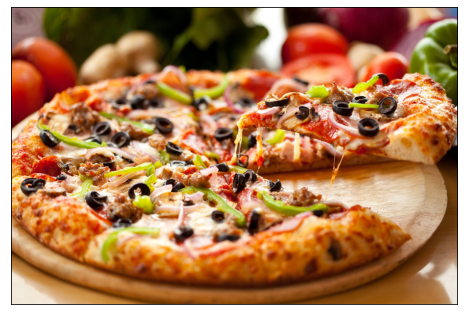

In [ ]:
TEST_IMAGE = 'e1372657d9a016f62ec0b88a7de21ad8.jpg'

img = plt.imread(TEST_IMAGE)

fig = plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

Формируем базовую модель, а веса загружаем из файла с наилучшей точностью для валидационной выборки.

In [ ]:
%%time
tf.keras.backend.clear_session()
model_best = create_model()
model_best.load_weights(os.path.join(MY_DRIVE_PATH, 'food101_wghts_loss1.06_acc0.75.hdf5'))

CPU times: user 4.2 s, sys: 238 ms, total: 4.44 s
Wall time: 4.45 s


In [ ]:
img = tf.keras.preprocessing.image.load_img(TEST_IMAGE, target_size=(299, 299))
img = tf.keras.preprocessing.image.img_to_array(img)                    
img = np.expand_dims(img, axis=0)         
img /= 255.

In [ ]:
preds = model_best.predict(img).flatten()
index = np.argmax(preds)
pred = full_classes_list[index]

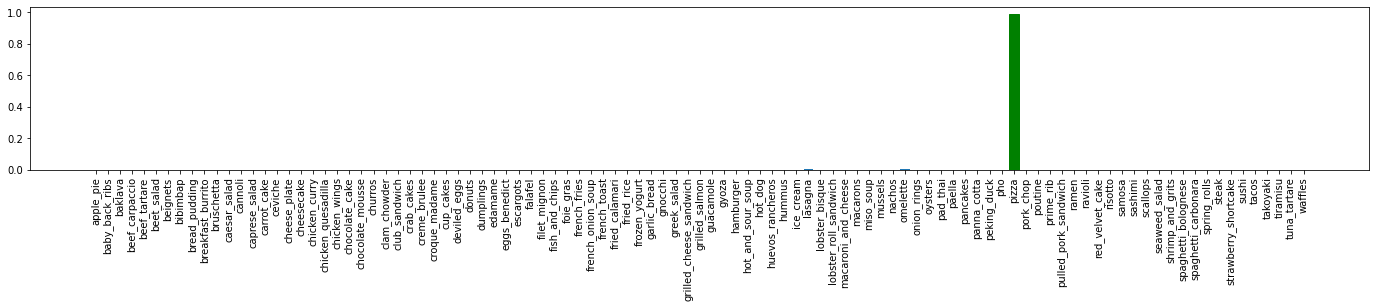

In [ ]:
fig = plt.figure(figsize=(24, 3))
mybar = plt.bar(range(N_CLASSES), preds)
plt.xticks(range(N_CLASSES), full_classes_list, rotation='vertical')
mybar[index].set_color('g')
plt.show()

А теперь попробуем немного посложнее

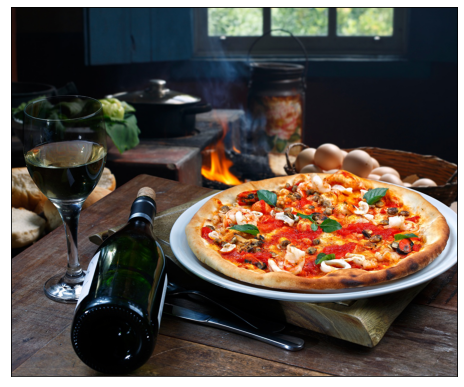

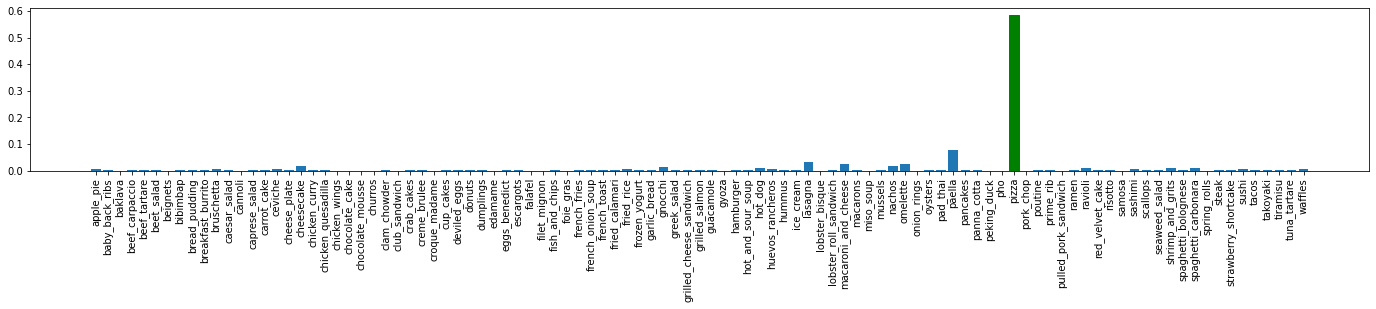

In [ ]:
#!wget https://s1.1zoom.ru/big0/160/Pizza_Bottle_Table_562132_1237x1024.jpg
TEST_IMAGE = 'Pizza_Bottle_Table_562132_1237x1024.jpg'

img = plt.imread(TEST_IMAGE)

fig = plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

img = tf.keras.preprocessing.image.load_img(TEST_IMAGE, target_size=(299, 299))
img = tf.keras.preprocessing.image.img_to_array(img)                    
img = np.expand_dims(img, axis=0)         
img /= 255.

preds = model_best.predict(img).flatten()
index = np.argmax(preds)
pred = full_classes_list[index]

fig = plt.figure(figsize=(24, 3))
mybar = plt.bar(range(N_CLASSES), preds)
plt.xticks(range(N_CLASSES), full_classes_list, rotation='vertical')
mybar[index].set_color('g')
plt.show()